In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
path = "../../../data/cleaned/pincher_station_hourly_wind_cleaned.csv"
required_columns = ['timestamp', 'temp_c', 'rel_humidity', 'wind_speed_kmh', 'pressure_kpa','u', 'v']
dtype_cast = {'wind_speed': float}


In [7]:
import os
import sys

# Get the absolute path of the directory containing the notebook (ensemble)
# Then get the parent directory's parent (which is the project root: wind-forecast-benchmark)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

# Add the project root to the system path
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [6]:
pwd

'/home/amir/Desktop/wind-forecast-benchmark/notebooks/non-linear/ensemble'

In [8]:
from modules.preprocessing import *

INFO:modules.preprocessing:preprocessing module loaded (v1.0.0)


In [9]:
import pandas as pd

In [10]:
test_df = pd.read_csv(path)

In [11]:
test_df.head()

,timestamp,temp_c,rel_humidity,wind_speed_kmh,pressure_kpa,wind_dir_deg,timestamp_rounded,u,v,pressure_24h
0,2011-06-27 14:00:00,7.9,85.0,9.0,88.14,320.0,2011-06-27 14:00:00,5.785088,-6.894400,88.140000
1,2011-06-27 15:00:00,11.5,74.0,8.0,88.11,320.0,2011-06-27 15:00:00,5.142301,-6.128356,88.125000
2,2011-06-27 16:00:00,15.4,61.0,5.0,88.04,320.0,2011-06-27 16:00:00,3.213938,-3.830222,88.096667
3,2011-06-27 17:00:00,17.3,48.0,8.0,87.99,40.0,2011-06-27 17:00:00,-5.142301,-6.128356,88.070000
4,2011-06-27 18:00:00,18.4,47.0,15.0,87.93,120.0,2011-06-27 18:00:00,-12.990381,7.500000,88.042000


In [12]:
test_df.columns

Index(['timestamp', 'temp_c', 'rel_humidity', 'wind_speed_kmh', 'pressure_kpa',
       'wind_dir_deg', 'timestamp_rounded', 'u', 'v', 'pressure_24h'],
      dtype='object')

In [13]:
df_basic_clean = load_and_basic_clean(path=path,
                                      required_columns=required_columns,
                                      sort_by='timestamp')

INFO:modules.preprocessing:Loaded CSV from '../../../data/cleaned/pincher_station_hourly_wind_cleaned.csv': 118474 rows, 10 columns
INFO:modules.preprocessing:Selected 7 required columns
INFO:modules.preprocessing:Sorted DataFrame by column 'timestamp'
INFO:modules.preprocessing:Data loading and cleaning completed successfully


In [14]:
df_basic_clean = df_basic_clean[0]

In [15]:
clmns = {
    'timestamp':'datetime',
    'temp_c':'temperature',
    'rel_humidity':'humidity',
    'wind_speed_kmh':'wind_speed',
    'pressure_kpa':'pressure',
    
}
df_basic_clean.rename(columns=clmns, inplace=True)

In [16]:
df_basic_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118474 entries, 0 to 118473
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     118474 non-null  object 
 1   temperature  118474 non-null  float64
 2   humidity     118474 non-null  float64
 3   wind_speed   118474 non-null  float64
 4   pressure     118474 non-null  float64
 5   u            118474 non-null  float64
 6   v            118474 non-null  float64
dtypes: float64(6), object(1)
memory usage: 6.3+ MB


In [17]:
df = df_basic_clean

In [18]:
df.head()

,datetime,temperature,humidity,wind_speed,pressure,u,v
0,2011-06-27 14:00:00,7.9,85.0,9.0,88.14,5.785088,-6.894400
1,2011-06-27 15:00:00,11.5,74.0,8.0,88.11,5.142301,-6.128356
2,2011-06-27 16:00:00,15.4,61.0,5.0,88.04,3.213938,-3.830222
3,2011-06-27 17:00:00,17.3,48.0,8.0,87.99,-5.142301,-6.128356
4,2011-06-27 18:00:00,18.4,47.0,15.0,87.93,-12.990381,7.500000


In [20]:
import numpy as np

In [21]:
# ensure the column is datetime *type*
df['date'] = pd.to_datetime(df['datetime'])   # or df['datetime'] if that's the name

# now extract hour
df['hour'] = df['date'].dt.hour
df['sin_h'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_h'] = np.cos(2 * np.pi * df['hour'] / 24)

In [23]:
def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

In [24]:
# 1. REVISED LAGS (Option 2)
# Keep recent history (1,2,3) and the exact time yesterday (24). 
# Drop the noisy lags (23, 25, 48).
LAGS = [1, 2, 3, 24] 
cols_to_lag = ['pressure', 'temperature', 'wind_speed', 'u', 'v']

# 2. Apply Lags
df_lags = make_lags(df, cols_to_lag, LAGS)
df_final = pd.concat([df, df_lags], axis=1)

# 3. Add Rolling Features (Trend & Volatility)
# Calculated on the CURRENT available data (at time t)
# This captures the "average weather of the last day" and "gustiness"
df_final['wind_rolling_24_mean'] = df_final['wind_speed'].rolling(window=24).mean()
df_final['wind_rolling_24_std'] = df_final['wind_speed'].rolling(window=24).std()

# 4. Target Creation & Cleanup
df_final['target_wind_speed'] = df_final['wind_speed'].shift(-1)
df_final.dropna(inplace=True)
X = df_final.drop(['datetime', 'target_wind_speed'], axis=1)
y = df_final['target_wind_speed']

In [25]:
# 3. train/test split (last 720 rows locked)
train_end = len(df_final) - 720
test_df = df_final.iloc[train_end:].copy()

current_obs = ['pressure', 'temperature', 'u', 'v', 'wind_speed']
FEATS = [c for c in df_final.columns if '_L' in c] + ['sin_h', 'cos_h'] + current_obs



In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats # Used for parameter distributions

# --- Assumed Setup (from your original code) ---
# df = ... (your DataFrame)
# FEATS = [...] (your list of feature names)
# train_end = ... (the index where initial training ends)
# test_df = df.iloc[train_end:].copy()
# m = ... (your metrics module, e.g., sklearn.metrics)
# -------------------------------------------------

### 1. Define Parameter Distribution for RandomizedSearch
# We use distributions (like uniform, loguniform) instead of a fixed grid
# This is much faster and more efficient for periodic tuning.
param_dist = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.loguniform(0.01, 0.3),
    'subsample': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'colsample_bytree': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'gamma': stats.uniform(0, 0.5),
    'reg_alpha': stats.loguniform(1e-3, 1.0),
    'reg_lambda': stats.loguniform(1e-3, 1.0),
}

### 2. Define Tuning and Retraining Settings
RETRAIN_INTERVAL = 168 # hours (weekly)
TUNING_WINDOW_HOURS = 2160 # Approx 3 months for tuning
N_ITER_RANDOM_SEARCH = 15 # Number of param combinations to try (faster)
N_SPLITS_INNER_CV = 3 # Fewer splits for speed during tuning


In [27]:

### 3. Rolling Retraining and Re-Tuning Loop
print("Starting rolling forecast with periodic re-tuning...")

preds = []
model = None # Start with no model
current_best_params = {} # Will be set on the first run

for t in range(train_end, len(df_final)):

    # Check if it's time to retrain and re-tune
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- Retraining and Re-Tuning at index {t} ---")
        
        # --- A. RE-TUNING on a SLIDING window ---
        # We tune on a *recent* window to adapt to new conditions
        tune_start_idx = max(0, t - TUNING_WINDOW_HOURS)
        tune_window_df = df_final.iloc[tune_start_idx:t]
        
        X_tune = tune_window_df[FEATS].values
        y_tune = tune_window_df['target_wind_speed'].values
        
        print(f"Running RandomizedSearch on window {tune_start_idx} to {t}...")
        
        # Use TimeSeriesSplit for the inner cross-validation
        tscv_inner = TimeSeriesSplit(n_splits=N_SPLITS_INNER_CV)
        
        rs = RandomizedSearchCV(
            estimator=xgb.XGBRegressor(objective='reg:absoluteerror', 
                                       random_state=42, n_jobs=-1),
            param_distributions=param_dist,
            n_iter=N_ITER_RANDOM_SEARCH, # Much faster than grid search
            cv=tscv_inner,
            scoring='neg_mean_absolute_error',
            verbose=0, # Set to 1 or more for details
            n_jobs=-1
        )
        
        rs.fit(X_tune, y_tune)
        
        # Update the parameters to use for this week's model
        current_best_params = rs.best_params_
        print(f"New best parameters found: {current_best_params}")

        # --- B. RE-TRAINING on an EXPANDING window ---
        # We train the final model on all available history
        # using the *newly found* best parameters.
        train_window_df = df_final.iloc[:t] 
        X_train_window = train_window_df[FEATS].values
        y_train_window = train_window_df['target_wind_speed'].values
        
        print(f"Retraining model on window 0 to {t}...")
        model = xgb.XGBRegressor(objective='reg:absoluteerror', 
                                 random_state=42, n_jobs=-1, 
                                 **current_best_params) # Use the new params
        
        model.fit(X_train_window, y_train_window)
        print("Model retrained successfully.")

    # --- C. PREDICTION ---
    # This happens every hour, using the most recently trained model
    
    # Handle the very first prediction if model isn't trained yet
    if model is None:
        # This case should be handled, e.g., by training a default
        # model before the loop. For this structure, we'll
        # just predict 0 or NaN for simplicity until first retrain.
        print("Waiting for first retraining cycle...")
        preds.append(np.nan) # Or a default value
        continue

    x_next = df_final.iloc[t][FEATS].values.reshape(1,-1)
    preds.append(model.predict(x_next)[0])


Starting rolling forecast with periodic re-tuning...

--- Retraining and Re-Tuning at index 117729 ---
Running RandomizedSearch on window 115569 to 117729...
New best parameters found: {'colsample_bytree': np.float64(0.9460742875128523), 'gamma': np.float64(0.08495137137943048), 'learning_rate': np.float64(0.07034270575272088), 'max_depth': 9, 'n_estimators': 873, 'reg_alpha': np.float64(0.5530518048912632), 'reg_lambda': np.float64(0.002635178130146633), 'subsample': np.float64(0.6835861232666928)}
Retraining model on window 0 to 117729...
Model retrained successfully.

--- Retraining and Re-Tuning at index 117897 ---
Running RandomizedSearch on window 115737 to 117897...
New best parameters found: {'colsample_bytree': np.float64(0.6130572533949658), 'gamma': np.float64(0.20739584127538035), 'learning_rate': np.float64(0.036927823920935646), 'max_depth': 3, 'n_estimators': 229, 'reg_alpha': np.float64(0.02723452933119618), 'reg_lambda': np.float64(0.003068840069904754), 'subsample': n

In [28]:
import sklearn.metrics as m

In [29]:

# --- 4. Evaluation ---
test_df['pred_xgb_dynamic'] = preds
# Drop any initial NaNs if we had them
test_df = test_df.dropna(subset=['pred_xgb_dynamic'])

print("\n--- Final Results ---")
print("XGB MAE with Dynamic Re-Tuning:", 
      m.mean_absolute_error(test_df['target_wind_speed'], test_df['pred_xgb_dynamic']))


--- Final Results ---
XGB MAE with Dynamic Re-Tuning: 6.2672274301449455


In [30]:
# Get feature importance
importance = pd.DataFrame({
    'feature': FEATS,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance.head(5))

          feature  importance
26     wind_speed    0.252112
8   wind_speed_L1    0.171294
24              u    0.161036
12           u_L1    0.103098
9   wind_speed_L2    0.087654


In [31]:
import numpy as np
import os

# Folder path
save_pred_path = "../../../results/"

# Ensure folder exists
os.makedirs(save_pred_path, exist_ok=True)

# Full file path
file_path = os.path.join(save_pred_path, "pincher_xgb_preds_1.npy")

# Save predictions
np.save(file_path, preds)

print(f"Saved predictions to {file_path}")


Saved predictions to ../../../results/pincher_xgb_preds_1.npy


In [32]:

# Folder to save
save_path = "../../../results/"
os.makedirs(save_path, exist_ok=True)  # create folder if missing

# Full file path
file_path = os.path.join(save_path, "pincher_y_test.npy")

# Save array
y_test = test_df['target_wind_speed']
np.save(file_path, y_test)

print(f"Saved y_test to {file_path}")


Saved y_test to ../../../results/pincher_y_test.npy


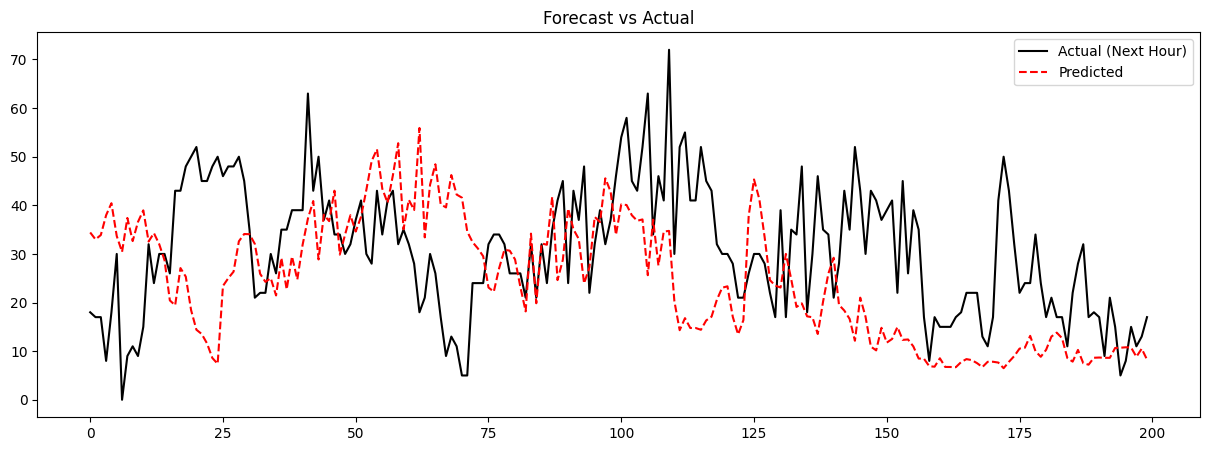

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_tune[-200:], label='Actual (Next Hour)', color='black')
plt.plot(preds[-200:], label='Predicted', color='red', linestyle='--')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()